In [1]:
import numpy as np
import os
import glob
import sys
import torch
from pathlib import Path

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
grandparent_dir = os.path.abspath(os.path.join(parent_dir, '..'))
sys.path.append(grandparent_dir)
print(grandparent_dir)

import gendata
import learner as ln
from learner.metric.dynamics_metric import (
    calculate_dynamics_metrics,
    plot_dynamics_metrics,
)
from utils import Logger, read_config_file, set_random_seed, tensors_to_numpy

/home/lbu/project/PINN_DE


In [2]:
from configs.config_plot import *

seed = 0
set_random_seed(seed)

os.makedirs(output_dir, exist_ok=True)  

# Logger
logger = Logger(output_dir)
logger.info("#" * 100)

2023-09-17 20:25:13 INFO ####################################################################################################


# infer

In [3]:
##################################################################
#
# load data and net
#
##################################################################
# config ----------------------------------------------------------------------------------------
config_file_path = "/home/lbu/project/PINN_DE/configs/train/scissor_space_deployable/config_pinn.py"
config = read_config_file(config_file_path)
config.dataset_path = "/home/lbu/project/PINN_DE/outputs/data/DynamicScissorSpaceDeployableDAE"
config.load_net_path = "/home/lbu/project/PINN_DE/outputs/task_scissor_space_deployable_pinn/train-model.pkl"

# data ----------------------------------------------------------------------------------------
data_args = {
    "config": config,
    "logger": logger,
}
data = ln.data.get_data(**data_args)
train_loader, val_loader = data
y0, y, yt, data_t, physics_t = next(iter(val_loader))

# net ----------------------------------------------------------------------------------------
net_args = {
    "config": config,
    "logger": logger,
}
net = ln.nn.get_model(**net_args)


# pred ----------------------------------------------------------------------------------------
q_hat, qt_hat, qtt_hat = net.get_q_qt_qtt(data_t)

# batch processing for big data
# q_hat_list = []
# qt_hat_list = []
# qtt_hat_list = []
# for i in range(20):
#     split_len = 235
#     ti = data_t[i*split_len: (i+1)*split_len].clone().detach().requires_grad_(True)
#     q_hat, qt_hat, qtt_hat = net.get_q_qt_qtt(ti)
#     q_hat_list.append(q_hat.clone().detach())
#     qt_hat_list.append(qt_hat.clone().detach())
#     qtt_hat_list.append(qtt_hat.clone().detach())

# q_hat = torch.cat(q_hat_list, axis=0)
# qt_hat = torch.cat(qt_hat_list, axis=0)
# qtt_hat = torch.cat(qtt_hat_list, axis=0)

2023-09-17 20:25:13 INFO =================>
2023-09-17 20:25:13 INFO Start get dataset...
2023-09-17 20:25:13 INFO Loading dataset from path: /home/lbu/project/PINN_DE/outputs/data/DynamicScissorSpaceDeployableDAE
2023-09-17 20:25:13 INFO DynamicData is loaded
2023-09-17 20:25:17 INFO =================>
2023-09-17 20:25:17 INFO Start get models...
2023-09-17 20:25:17 INFO PINN loaded
2023-09-17 20:25:17 INFO Number of parameters in model: 11350
2023-09-17 20:25:17 INFO Network loaded from '/home/lbu/project/PINN_DE/outputs/task_scissor_space_deployable_pinn/train-model.pkl'


Successfully loaded pretrained weights from "/home/lbu/project/PINN_DE/outputs/task_scissor_space_deployable_pinn/train-model.pkl"


In [4]:
##################################################################
#
# Calculate the error
#
##################################################################
# to numpy 
data_t = tensors_to_numpy(data_t)
q, qt = np.split(y, 2, axis=-1)
qt, qtt = np.split(yt, 2, axis=-1)
q, qt, qtt = tensors_to_numpy(q, qt, qtt)
all_states = np.concatenate([q, qt, qtt], axis=-1)

q_hat, qt_hat, qtt_hat = tensors_to_numpy(q_hat, qt_hat, qtt_hat)
all_states_hat = np.concatenate([q_hat, qt_hat, qtt_hat], axis=-1)

# Calculate energy and other terms using the physics model
(
    metric_value,
    metric_error_value,
    output_log_string,
) = calculate_dynamics_metrics(
    calculator=net.right_term_net.calculator,
    pred_data=[q_hat, qt_hat, qtt_hat],
    gt_data=[q, qt, qtt],
)

energy, kinetic, potential, phi, phi_t, phi_tt = metric_value
mean_energy_error, max_energy_error, phi_error, phi_t_error, phi_tt_error = metric_error_value
output_metric = " | ".join(output_log_string)
logger.info(output_metric)

2023-09-17 20:25:17 INFO Mean energy error: 1.4293e+04 | Max energy error: 4.6279e+02 | Phi error: 8.7899e-04 | Phi_t error: 1.5282e-03 | Phi_tt error: 1.2639e-02


In [5]:
len(q_hat)

472

In [6]:
# plot_dynamics_metrics(
#     config=config,
#     pred_data=[q_hat, qt_hat, qtt_hat],
#     gt_data=[q, qt, qtt],
#     t=data_t,
# )

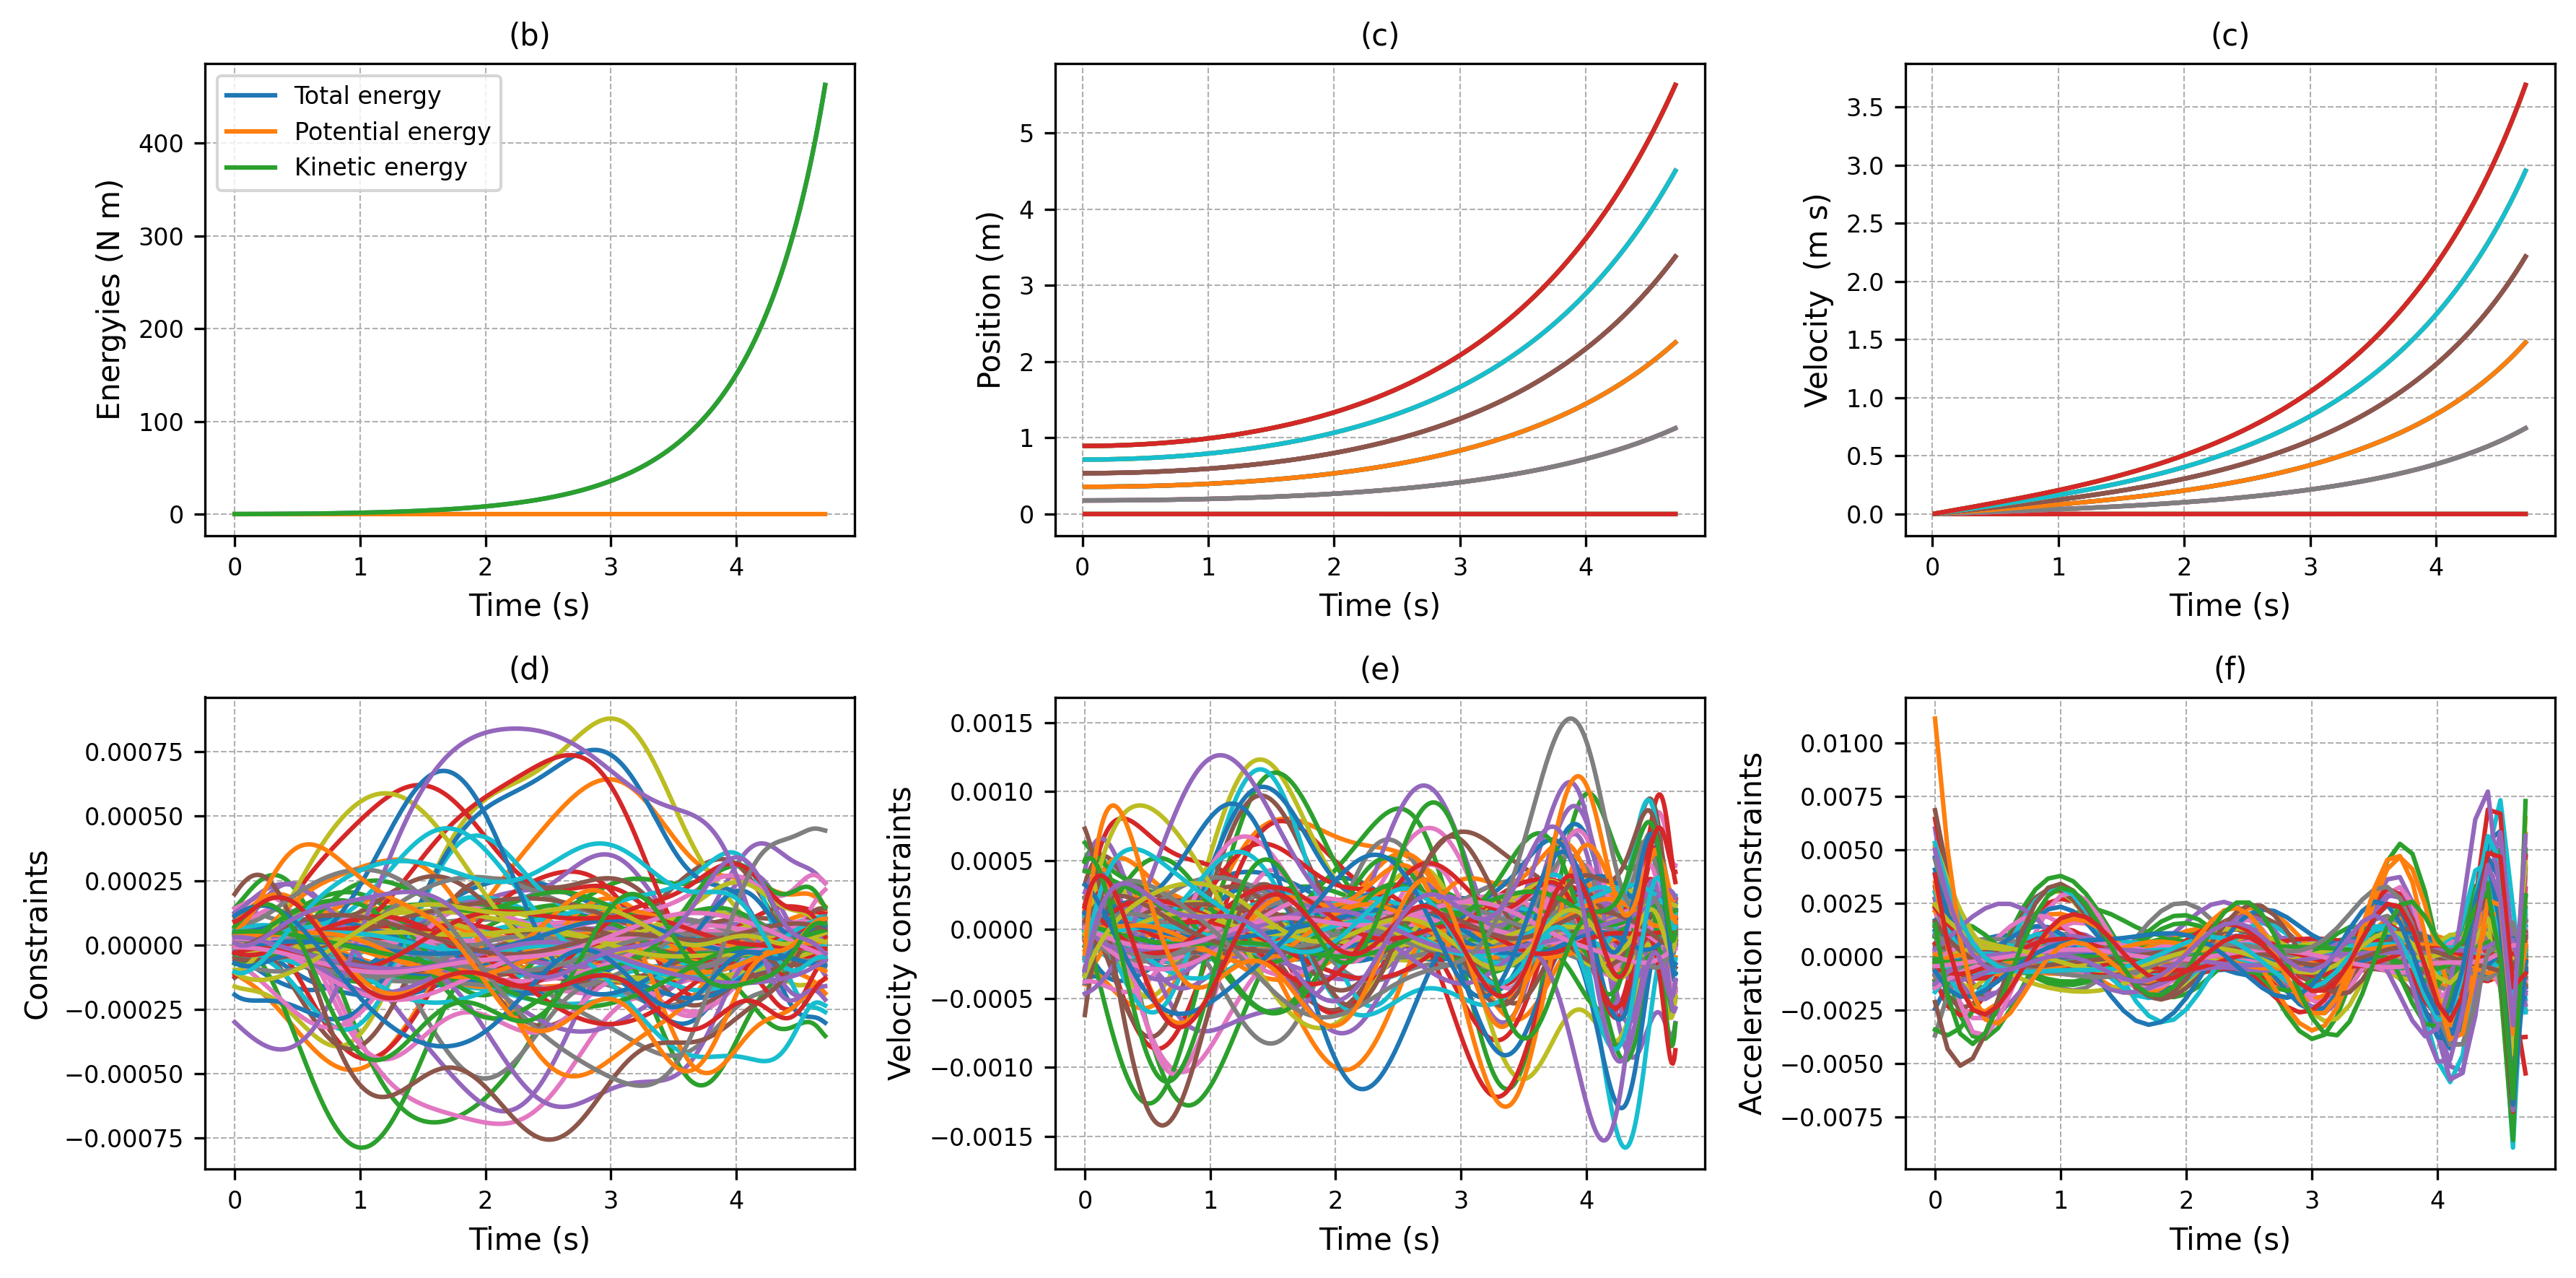

In [7]:
# fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2), dpi=DPI)
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2), dpi=Latex_DPI)

subfig = axs[0, 0]
subfig.set_title('(b)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Energyies (N m)')
subfig.plot(data_t, energy, label='Total energy')
subfig.plot(data_t, potential, label='Potential energy')
subfig.plot(data_t, kinetic, label='Kinetic energy')
subfig.legend()

subfig = axs[0, 1]
subfig.set_title('(c)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Position (m)')
# subfig.plot(data_t, q_hat[:,-1], label='Top point of the structure')
subfig.plot(data_t[2:], q_hat[2:,2::3])
# subfig.legend()

subfig = axs[0, 2]
subfig.set_title('(c)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Velocity  (m s)')
subfig.plot(data_t[2:], qt_hat[2:,2::3])
# subfig.legend()

subfig = axs[1, 0]
subfig.set_title('(d)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Constraints')
subfig.plot(data_t, phi[:, :])

subfig = axs[1, 1]
subfig.set_title('(e)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Velocity constraints')
subfig.plot(data_t, phi_t[:, :])

subfig = axs[1, 2]
subfig.set_title('(f)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Acceleration constraints')
subfig.plot(data_t[::10], phi_tt[::10, :])

plt.tight_layout()